`Гринда Юліана`

`Єлісєєв Гордій`

## Objective:

The objective of this study is to compare the performance and efficiency of custom implementations of various graph algorithms, including Kruskal's, Prim's, Bellman-Ford's, and Floyd-Warshall's algorithms, against their corresponding built-in implementations. Through this comparison, we aim to evaluate the effectiveness of custom implementations in terms of computational efficiency and scalability, and to identify scenarios where built-in implementations offer superior performance.

In [8]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby

## Generating graph

In [7]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

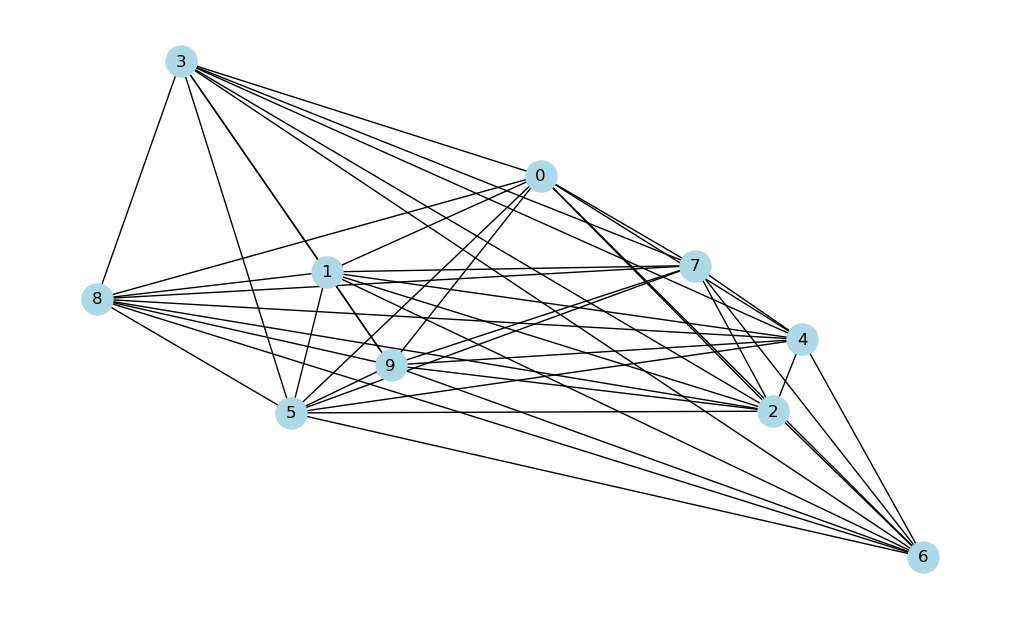

In [8]:
G = gnp_random_connected_graph(10, 1, False, True)
# print(G)

# For Task 1

## Kruskal's algorithm

In [9]:
from networkx.algorithms import tree

In [10]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

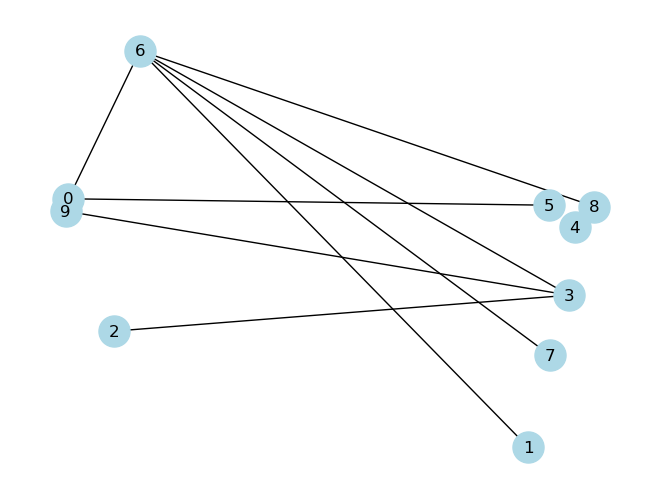

In [11]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [12]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 5), (0, 6), (1, 6), (2, 3), (3, 6), (3, 9), (4, 8), (6, 7), (6, 8)]),
 9)

This function, `kruskal(graph, draw: bool = False)`, implements Kruskal's algorithm to find the minimum spanning tree of an 
undirected graph provided as input. It sorts the edges of the graph by weight, then iteratively adds the lowest weight edges 
that do not form cycles until all nodes are connected. If `draw` is set to True, it also visualizes the resulting minimum 
spanning tree using NetworkX and Matplotlib.

In [13]:
def kruskal(graph, draw: bool = False):
    """
    Kruskal's algorithm for finding the minimum spanning tree of a graph.

    Parameters:
    - graph: NetworkX Graph. An undirected graph.

    Returns:
    - Minimum spanning tree as a NetworkX Graph.

    Example:
    >>> G = nx.Graph()
    >>> G.add_edges_from([(0, 1, {'weight': 1}), (1, 2, {'weight': 2}), (2, 0, {'weight': 3})])
    >>> mst = kruskal(G)
    [(0, 1, {'weight': 1}), (1, 2, {'weight': 2})]
    """
    edges = sorted(list(graph.edges(data=True)), key = lambda x: x[2]['weight'])
    num_nodes = nx.number_of_nodes(graph)

    kruskal_graph = nx.Graph()
    new_edges = []
    sets_of_vertices = [{num} for num in range(num_nodes)]

    while len(new_edges) != num_nodes - 1:
        edge = edges.pop(0)
        value = 0
        for i, vertices_set in enumerate(sets_of_vertices):
            if edge[0] in vertices_set:
                u_set = (i, vertices_set)
                value += 1
            if edge[1] in  vertices_set:
                v_set = (i, vertices_set)
                value += 1
            if value == 2:
                break

        if u_set != v_set:
            sets_of_vertices.remove(u_set[1])
            sets_of_vertices.remove(v_set[1])
            sets_of_vertices.append(u_set[1].union(v_set[1]))
            new_edges.append((edge[0], edge[1], edge[2]['weight']))

    kruskal_graph.add_weighted_edges_from(new_edges)

    if draw:
        plt.figure(figsize=(10,6))
        nx.draw(kruskal_graph, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return kruskal_graph

## Prim's algorithm

In [14]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

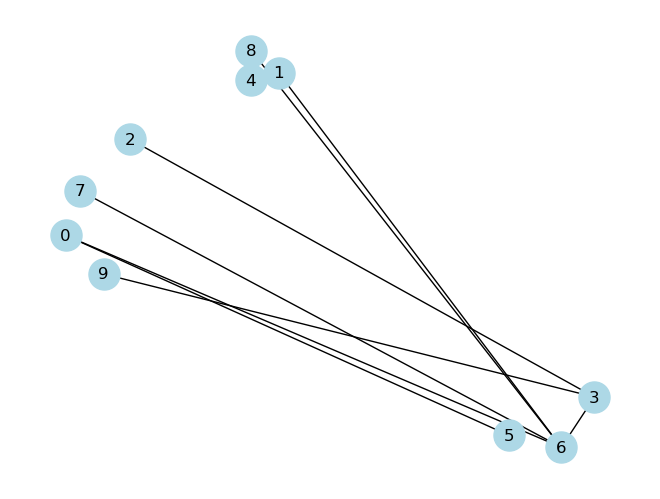

In [15]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [16]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 5), (0, 6), (1, 6), (2, 3), (3, 6), (3, 9), (4, 8), (6, 7), (6, 8)]),
 9)

This function, `prim(graph, draw=False)`, implements Prim's algorithm to find the minimum spanning tree (MST) of an input graph. It assumes the graph is connected and requires edge weights specified as a 'weight' attribute in the edge data. The function iteratively adds the lowest weight edges that connect visited nodes until all nodes are visited. If `draw` is set to True, it also visualizes the resulting minimum spanning tree using NetworkX and Matplotlib.

In [17]:
def prim(graph, draw=False):
    """
    Finds the minimum spanning tree (MST) of a graph using Prim's algorithm.

    Parameters:
    graph (nx.Graph): The input graph.
    draw (bool): Whether to visualize the MST. Default is False.

    Returns:
    nx.Graph: The minimum spanning tree of the input graph.

    Notes:
    - This function assumes that the input graph is connected.
    - The graph should have edge weights specified as 'weight' attribute in the edge data.
    """
    nodes = set(graph.nodes())
    prim_graph = nx.Graph()
    visited_nodes = set()
    num_nodes = len(nodes)

    start_node = next(iter(nodes))
    visited_nodes.add(start_node)

    while len(visited_nodes) < num_nodes:
        min_edge = None
        min_weight = float('inf')

        for u in visited_nodes:
            for v in graph.neighbors(u):
                if v not in visited_nodes:
                    weight = graph.edges[u, v]['weight']
                    if weight < min_weight:
                        min_weight = weight
                        min_edge = (u, v)

        u, v = min_edge
        prim_graph.add_edge(u, v, weight=min_weight)
        visited_nodes.add(v)

    if draw:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        nx.draw(prim_graph, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return prim_graph

# For Task 2

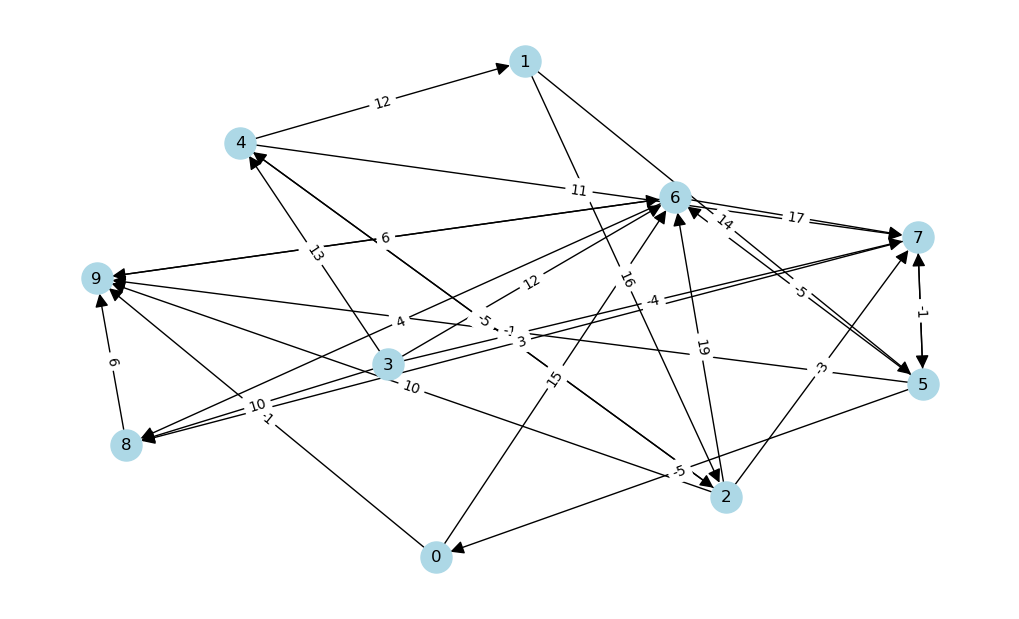

In [18]:
G = gnp_random_connected_graph(10, 0.5, True, True)

## Bellman-Ford algorithm

In [19]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [20]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 6: 5
Distance to 9: -1
Distance to 7: 22
Distance to 8: 9
Distance to 5: 21


This code defines a class `Graph1` to implement Bellman-Ford's algorithm for finding the shortest path from a given start vertex in a graph. The class initializes with the graph's nodes and edges separately, provides a method `BellFord` to execute the algorithm, and a method `get_result` to print the resulting shortest path distances. It iteratively relaxes edges to find the shortest paths and checks for the existence of negative weight cycles. If found, it prints a message indicating their presence.

In [64]:
#Bellmann-Ford's algorithm
class Graph1:
    def __init__(self, graph):
        '''get amount of nodes and list of edges separetly'''
        self.nodes = list(graph.nodes())
        self.edges = list(graph.edges(data = True))

    def get_result(self, table):
        '''fill the table of result'''
        for i in range(len(self.nodes)):
            print (i, table[i])
        
    def BellFord(self, str_v):
        #Initial initialization of B-F's algorithm - first step
        table = [float('inf')] * len(self.nodes)
        table[str_v] = 0 
        #realization of step move of B-F's algorith - second step
        for i in range(len(self.nodes) - 1):
            for u, v, k in self.edges:
                if table[u] != float('inf') and table[v] > table[u] + k['weight']:
                    table[v] =  table[u] + k['weight'] 
        # verificate of negative weight cycle existation
        for u, v, k in self.edges:
                if table[u] != float('inf') and table[v] > table[u] + k['weight']:
                    print('Exist negative weight cycle') 
                    return
    
        # self.get_result(table)
        return table

## Floyd-Warshall algorithm

In [23]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [24]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 6: 5, 9: -1, 1: inf, 2: inf, 3: inf, 4: inf, 5: 21, 7: 22, 8: 9}
Distances with 1 source: {1: 0, 2: 16, 5: 12, 0: 7, 3: inf, 4: 33, 6: 7, 7: 13, 8: 11, 9: 6}
Distances with 2 source: {2: 0, 4: 17, 6: -9, 7: -3, 9: -10, 0: -9, 1: 29, 3: inf, 5: -4, 8: -5}
Distances with 3 source: {3: 0, 8: -6, 4: 13, 6: -10, 7: -4, 0: -10, 1: 25, 2: 8, 5: -5, 9: -11}
Distances with 4 source: {4: 0, 1: 12, 2: -5, 7: -8, 0: -14, 3: inf, 5: -9, 6: -14, 8: -10, 9: -15}
Distances with 5 source: {5: 0, 0: -5, 6: -5, 7: 8, 9: -6, 1: inf, 2: inf, 3: inf, 4: inf, 8: -1}
Distances with 6 source: {6: 0, 7: 17, 8: 4, 9: 9, 0: 11, 1: inf, 2: inf, 3: inf, 4: inf, 5: 16}
Distances with 7 source: {7: 0, 5: -1, 8: -2, 0: -6, 1: inf, 2: inf, 3: inf, 4: inf, 6: -6, 9: -7}
Distances with 8 source: {8: 0, 9: 6, 0: 23, 1: inf, 2: inf, 3: inf, 4: inf, 5: 28, 6: 12, 7: 29}
Distances with 9 source: {9: 0, 6: 6, 0: 17, 1: inf, 2: inf, 3: inf, 4: inf, 5: 22, 7: 23, 8: 10}


This code defines a class `Graph2` to implement the Floyd-Warshall algorithm for finding the shortest paths between all pairs of vertices in a graph. The class initializes with the graph's nodes and edges separately, provides a method `FloWarsh` to execute the algorithm, and a method `get_result` to print the resulting shortest path distances. It iteratively updates a distance matrix to find the shortest paths and checks for the existence of negative weight cycles. If found, it prints a message indicating their presence.

In [67]:
#Floyd-Warshall algorithm
class Graph2:
    def __init__(self, graph):
        '''get amount of nodes and list of edges separetly'''
        self.nodes = list(graph.nodes())
        self.edges = list(graph.edges(data = True))

    def get_result(self, table):
        '''fill the table of result'''
        for i in range(len(self.nodes)):
            print(f'Distance from {i}:', end ='')
            for j in range(len(self.nodes)):
                print(table[i][j], end = ' ')
            print()

    def FloWarsh(self):
        #create inf-table
        table = [[float('inf') for i in range(len(self.nodes))] for j in range(len(self.nodes))]
        #diagonal elements = 0
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if i == j:
                    table[i][j] = 0
        #other elements of table is graph's weight
        for v, u, k in self.edges:
            table[v][u] = k['weight']
        
        for k in range(len(self.nodes)):
            for i in range(len(self.nodes)):
                for j in range(len(self.nodes)):
                    table[i][j] = min(table[i][j], table[i][k] + table[k][j])
        
        # verificate of negative weight cycle existation
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if i == j and table[i][j] != 0:
                    print('Exist negative weight cycle') 
                    return
                    

        # self.get_result(table)
        return table
        

## Some useful explanations

### How to get list of edges for your algorithm

In [31]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [32]:
edges[:5]

[(0, 1), (0, 3), (0, 4), (0, 5), (0, 6)]

### To get edges with weights

In [33]:
edges = list(G.edges(data=True))

In [34]:
edges[:5]

[(0, 1, {'weight': 9}),
 (0, 3, {'weight': 1}),
 (0, 4, {'weight': 9}),
 (0, 5, {'weight': 15}),
 (0, 6, {'weight': -3})]

In [35]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [26]:
import time
from tqdm import tqdm

In [37]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  5%|▍         | 49/1000 [00:00<00:04, 236.67it/s]

100%|██████████| 1000/1000 [00:04<00:00, 242.23it/s]


0.0013509366512298583

## Comparison of Kruskal and Prim Algorithms

As you can see in the graph, the implementation of our Kruskal algorithm is significantly better than the Prim algorithm. This may be due to the fact that Kruskal's algorithm does not need to find incident edges, unlike Prim's algorithm.

100%|██████████| 1000/1000 [00:00<00:00, 25377.11it/s]


100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


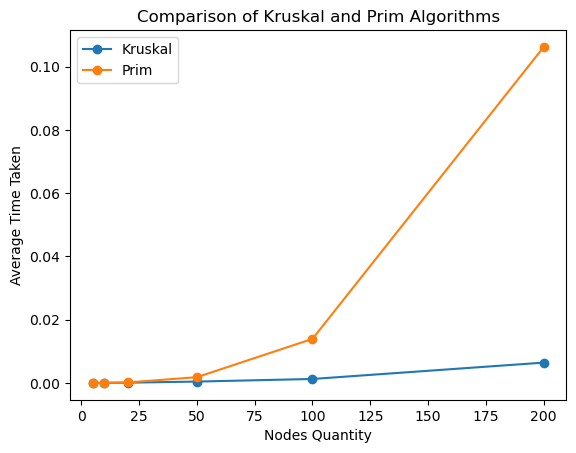

In [28]:
NUM_OF_ITERATIONS = 1000
result1 = {}
time_taken = 0
nodes = [5, 10, 20, 50, 100, 200]

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        kruskal(G)
        end = time.time()
        time_taken += end - start
        result1[node] = time_taken

time_taken = 0
result2 = {}

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        prim(G)
        end = time.time()
        time_taken += end - start
        result2[node] = time_taken


plt.plot(nodes, list(result1.values()), label='Kruskal', marker='o')
plt.plot(nodes, list(result2.values()), label='Prim', marker='o')
plt.xlabel('Nodes Quantity')
plt.ylabel('Average Time Taken')
plt.title('Comparison of Kruskal and Prim Algorithms')
plt.legend()
plt.show()

## Comparison of Kruskal and Kruskal built-in Algorithms

For a small number of vertices, our Kruskal algorithm and the built-in algorithm are practically indistinguishable in terms of running time, but as the number of vertices increases, we can see that our algorithm is more efficient.

100%|██████████| 1000/1000 [00:23<00:00, 41.77it/s]


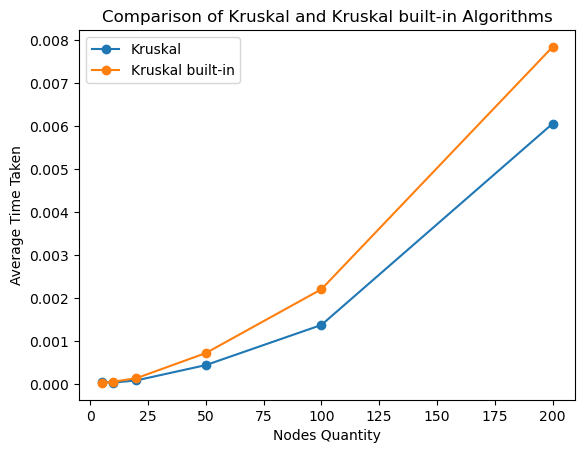

In [29]:
NUM_OF_ITERATIONS = 1000
result1 = {}
time_taken = 0
nodes = [5, 10, 20, 50, 100, 200]

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        kruskal(G)
        end = time.time()
        time_taken += end - start
        result1[node] = time_taken

time_taken = 0
result2 = {}

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="kruskal")
        end = time.time()
        time_taken += end - start
        result2[node] = time_taken

plt.plot(nodes, list(result1.values()), label='Kruskal', marker='o')
plt.plot(nodes, list(result2.values()), label='Kruskal built-in', marker='o')
plt.xlabel('Nodes Quantity')
plt.ylabel('Average Time Taken')
plt.title('Comparison of Kruskal and Kruskal built-in Algorithms')
plt.legend()
plt.show()

## Comparison of Prim and Prim in-built Algorithms

Similar to Kruskal's algorithms, when the number of vertices in the graph increases, the efficiency of our Prim's algorithm becomes significantly lower compared to the built-in Prim's algorithm.

100%|██████████| 1000/1000 [00:00<00:00, 32838.04it/s]


100%|██████████| 1000/1000 [00:20<00:00, 49.81it/s]


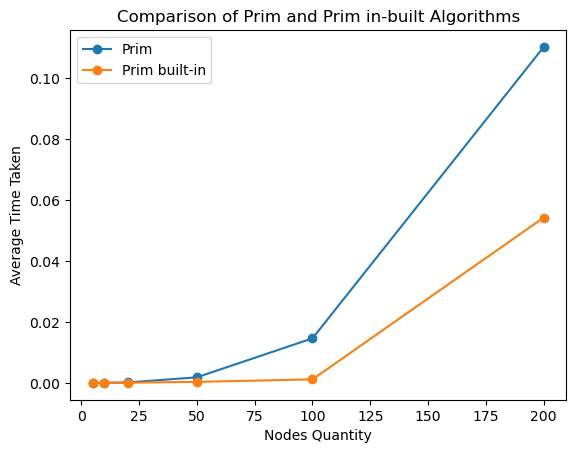

In [30]:
NUM_OF_ITERATIONS = 1000
result1 = {}
time_taken = 0
nodes = [5, 10, 20, 50, 100, 200]

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        prim(G)
        end = time.time()
        time_taken += end - start
        result1[node] = time_taken

time_taken = 0
result2 = {}

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="prim")
        end = time.time()
        time_taken += end - start
        result2[node] = time_taken

plt.plot(nodes, list(result1.values()), label='Prim', marker='o')
plt.plot(nodes, list(result2.values()), label='Prim built-in', marker='o')
plt.xlabel('Nodes Quantity')
plt.ylabel('Average Time Taken')
plt.title('Comparison of Prim and Prim in-built Algorithms')
plt.legend()
plt.show()

## Comparison of Bellman-Ford and Bellman-Ford in-built Algorithms

Our implementation of the Bellman-Ford algorithm is quite similar to the built-in algorithm, but the running time of the built-in Bellman-Ford algorithm is slightly better.

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s]


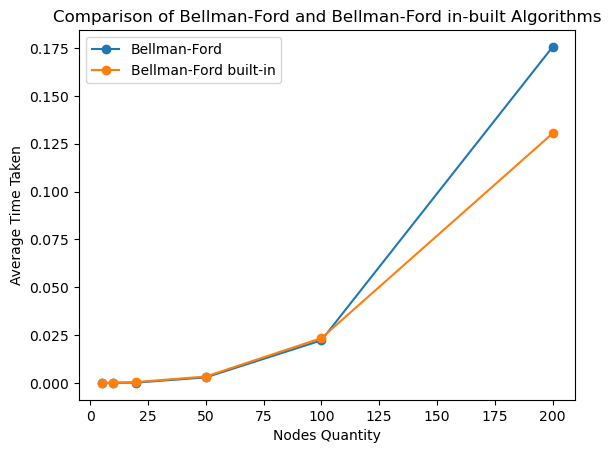

In [43]:
NUM_OF_ITERATIONS = 1000
result1 = {}
time_taken = 0
nodes = [5, 10, 20, 50, 100, 200]

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        Graph1(G).BellFord(0)
        end = time.time()
        time_taken += end - start
        result1[node] = time_taken

time_taken = 0
result2 = {}

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        try:
            pred, dist = bellman_ford_predecessor_and_distance(G, 0)
        except:
            pass
        end = time.time()
        time_taken += end - start
        result2[node] = time_taken

plt.plot(nodes, list(result1.values()), label='Bellman-Ford', marker='o')
plt.plot(nodes, list(result2.values()), label='Bellman-Ford built-in', marker='o')
plt.xlabel('Nodes Quantity')
plt.ylabel('Average Time Taken')
plt.title('Comparison of Bellman-Ford and Bellman-Ford in-built Algorithms')
plt.legend()
plt.show()

## Comparison of Floyd-Worhall and Floyd-Worhall in-built Algorithms

Our Floyd-Warshell algorithm is slightly more efficient for a larger number of graph vertices, but overall the performance of these two implementations of the algorithm is very similar.

100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


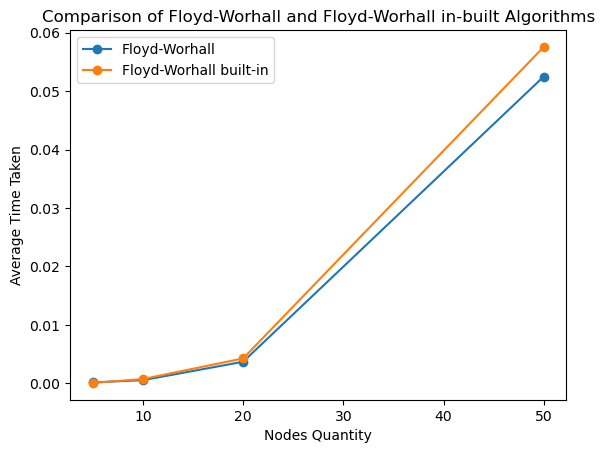

In [70]:
NUM_OF_ITERATIONS = 1000
result1 = {}
time_taken = 0
nodes = [5, 10, 20, 50]

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        Graph2(G).FloWarsh()
        end = time.time()
        time_taken += end - start
        result1[node] = time_taken

time_taken = 0
result2 = {}

for node in nodes:
    for i in tqdm(range(NUM_OF_ITERATIONS)):
        time_taken = 0
        G = gnp_random_connected_graph(node, 0.4, False)
        start = time.time()
        try:
            pred, dist = floyd_warshall_predecessor_and_distance(G)
        except:
            pass
        end = time.time()
        time_taken += end - start
        result2[node] = time_taken

plt.plot(nodes, list(result1.values()), label='Floyd-Worhall', marker='o')
plt.plot(nodes, list(result2.values()), label='Floyd-Worhall built-in', marker='o')
plt.xlabel('Nodes Quantity')
plt.ylabel('Average Time Taken')
plt.title('Comparison of Floyd-Worhall and Floyd-Worhall in-built Algorithms')
plt.legend()
plt.show()

## CONCLUSION

In conclusion, the comparison of various graph algorithms reveals insights into their performance and efficiency. Kruskal's algorithm demonstrates superiority over Prim's algorithm, particularly attributed to its simpler nature that doesn't require finding incident edges. Comparing custom implementations with built-in ones, we observe that for smaller graphs, custom algorithms may perform comparably, but as the graph size increases, built-in algorithms tend to outperform custom ones due to potential optimizations. Bellman-Ford's custom implementation closely matches its built-in counterpart, with a slight advantage in running time for the latter. Similarly, for Floyd-Warshall algorithm, while our custom implementation shows competitive performance, the built-in variant demonstrates marginally better efficiency, especially for larger graphs.